I will be using the Stack overflow dataset.I have grabbed around 2k sample for 4 tags iphone, jave, javascript, python
I will be building a deep learning model using keras.

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.884664384999951
GPU (s):
0.20824364899999637
GPU speedup over CPU: 18x


In [1]:
# Import Libraries
import keras
import numpy as np
from keras.preprocessing.text import Tokenizer
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

Using TensorFlow backend.


In [2]:
# Read csv file from dir.
data = pd.read_csv('stackoverflow.csv')

In [3]:
data.head()

,post,tags
0,conventions of importing python main programs ...,python
1,python write to file based on offset i want t...,python
2,enable a textbox on the selection of no from t...,javascript
3,sending mms and email from within app how doe...,iphone
4,why aren t java weak references counted as ref...,java


In [4]:
# class distributions
data.tags.value_counts()

iphone        2000
javascript    2000
python        2000
java          2000
Name: tags, dtype: int64

**Preprocessing Text**


Now that we have finished duplication our data requries some preprocessing before we go on further with analysis and making the predicition model.

Hence in the Preprocessing phase we do the following in the order below:-



1.   Begin by removing the html tags
2.   Removing any punchuations or limited set of special charaters like, or.or#etc
3.    Check if the word is made up of english letter and is not alpha-numeric
4.    Check to se if the length of the word is greater than 2(as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word(it was obsereved to be better than Porter Stemming)




In [5]:
# Prining some random posts
sent_0 = data['post'].values[0]
print(sent_0)
print("="*50)

sent_1000 = data['post'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = data['post'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = data['post'].values[4900]
print(sent_4900)
print("="*50)

conventions of importing python main programs  often i write command line utilities that are only meant to be run as main. for example  i might have a file that looks like this:   <pre><code>#!/usr/bin/env python  if __name__ ==  __main__ :     import sys     # do stuff </code></pre>   in other words  there is nothing going on that isn t under the if statement checking that this file is being run as main. i tried importing a file like this to see what would happen  and the import was successful.    so as i expected  one is allowed to import files like this  but what is the convention surrounding this practice  is one supposed to throw an error telling the user that there is nothing to be imported  or if all the contents of the file are supposed to be run as main  does one need to check if the program is being run as main  or is the conditional not necessary      also  if i have import statements  should they be at the top of the file  or under the conditional  if the modules are only b

In [6]:
import re
# removing urls from text python: http://stackflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+","",sent_0)
sent_1000 = re.sub(r"http\S+","",sent_1000)
sent_1500 = re.sub(r"http\S+","",sent_1500)
sent_4900 = re.sub(r"http\S+","",sent_4900)
print(sent_0)

conventions of importing python main programs  often i write command line utilities that are only meant to be run as main. for example  i might have a file that looks like this:   <pre><code>#!/usr/bin/env python  if __name__ ==  __main__ :     import sys     # do stuff </code></pre>   in other words  there is nothing going on that isn t under the if statement checking that this file is being run as main. i tried importing a file like this to see what would happen  and the import was successful.    so as i expected  one is allowed to import files like this  but what is the convention surrounding this practice  is one supposed to throw an error telling the user that there is nothing to be imported  or if all the contents of the file are supposed to be run as main  does one need to check if the program is being run as main  or is the conditional not necessary      also  if i have import statements  should they be at the top of the file  or under the conditional  if the modules are only b

In [7]:
pip install lxml

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

conventions of importing python main programs  often i write command line utilities that are only meant to be run as main. for example  i might have a file that looks like this:   #!/usr/bin/env python  if __name__ ==  __main__ :     import sys     # do stuff    in other words  there is nothing going on that isn t under the if statement checking that this file is being run as main. i tried importing a file like this to see what would happen  and the import was successful.    so as i expected  one is allowed to import files like this  but what is the convention surrounding this practice  is one supposed to throw an error telling the user that there is nothing to be imported  or if all the contents of the file are supposed to be run as main  does one need to check if the program is being run as main  or is the conditional not necessary      also  if i have import statements  should they be at the top of the file  or under the conditional  if the modules are only being used under the cond

In [9]:
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\t", "can not", phrase)

  # general
  phrase = re.sub(r"n\t", "not", phrase)
  phrase = re.sub(r"\'re", "are", phrase)
  phrase = re.sub(r"\'s", "is", phrase)
  phrase = re.sub(r"\'d", "would", phrase)
  phrase = re.sub(r"\'ll", "will", phrase)
  phrase = re.sub(r"\'t", "not", phrase)
  phrase = re.sub(r"\'ve", "have", phrase)
  phrase = re.sub(r"\'m", "am", phrase)
  return phrase

In [10]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

how to move image using uiaccelerometer   how to move image when i am moving iphone


In [11]:
# remove words with numbers
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

conventions of importing python main programs  often i write command line utilities that are only meant to be run as main. for example  i might have a file that looks like this:   <pre><code>#!/usr/bin/env python  if __name__ ==  __main__ :     import sys     # do stuff </code></pre>   in other words  there is nothing going on that isn t under the if statement checking that this file is being run as main. i tried importing a file like this to see what would happen  and the import was successful.    so as i expected  one is allowed to import files like this  but what is the convention surrounding this practice  is one supposed to throw an error telling the user that there is nothing to be imported  or if all the contents of the file are supposed to be run as main  does one need to check if the program is being run as main  or is the conditional not necessary      also  if i have import statements  should they be at the top of the file  or under the conditional  if the modules are only b

In [12]:
# remove special character
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ',sent_1500)
print(sent_1500)

how to move image using uiaccelerometer how to move image when i am moving iphone


In [13]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [14]:
# Combining all the above sentances
from tqdm import tqdm
preprocessed_posts=[]
# tqdm is for printing the status bar
for sentance in tqdm(data['post'].values):
  sentance = re.sub(r"http\S+", "", sentance)
  sentance = BeautifulSoup(sentance, 'lxml').get_text()
  sentance = decontracted(sentance)
  sentance = re.sub("\S*\d\S*", "",sentance).strip()
  sentance = re.sub('[^A-Za-z]+', ' ', sentance)
  
  sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)

  preprocessed_posts.append(sentance.strip())

100%|██████████| 8000/8000 [00:09<00:00, 876.03it/s] 


In [15]:
preprocessed_posts[1500]

'move image using uiaccelerometer move image moving iphone'

In [16]:
data['CleanText'] = preprocessed_posts

In [17]:
data.head()

,post,tags,CleanText
0,conventions of importing python main programs ...,python,conventions importing python main programs oft...
1,python write to file based on offset i want t...,python,python write file based offset want create pyt...
2,enable a textbox on the selection of no from t...,javascript,enable textbox selection no drop menu drop men...
3,sending mms and email from within app how doe...,iphone,sending mms email within app one get pop menu ...
4,why aren t java weak references counted as ref...,java,java weak references counted references garbag...


**Convert tags to integers as most of the machine learning models deal with integer or float**


Alternative way would be to use LabelEncoder and fit the tags columns on it

In [18]:
data['target'] = data.tags.astype('category').cat.codes

**Calculate the number of words in each posts**

We would like to look at the word distribution across all posts. This information would be key later when we are passing the data to Keras Deep Model.

In [19]:
data['num_words'] = data.CleanText.apply(lambda x : len(x.split()))

In [20]:
data.head()

,post,tags,CleanText,target,num_words
0,conventions of importing python main programs ...,python,conventions importing python main programs oft...,3,91
1,python write to file based on offset i want t...,python,python write file based offset want create pyt...,3,224
2,enable a textbox on the selection of no from t...,javascript,enable textbox selection no drop menu drop men...,2,28
3,sending mms and email from within app how doe...,iphone,sending mms email within app one get pop menu ...,0,31
4,why aren t java weak references counted as ref...,java,java weak references counted references garbag...,1,16


**Binning the posts by word count**

Ideally we would want to know how many posts are short, medium and large posts. Binning is a technique is efficient mechanism to do that

In [21]:
bins = [0, 50, 75, np.inf]
data['bins'] = pd.cut(data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500', '500-800', '>800'])

In [22]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [23]:
word_distribution.head()

,bins,counts
0,0-100,6240
1,100-300,1570
2,300-500,125
3,500-800,43
4,>800,22


Text(0.5, 1.0, 'Word distribution per bin')

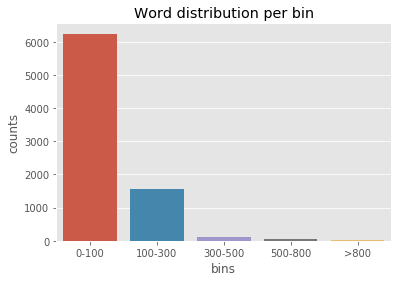

In [24]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

Post transformation this is how our pandas dataframe will look like

In [25]:
data.head()

,post,tags,CleanText,target,num_words,bins
0,conventions of importing python main programs ...,python,conventions importing python main programs oft...,3,91,0-100
1,python write to file based on offset i want t...,python,python write file based offset want create pyt...,3,224,100-300
2,enable a textbox on the selection of no from t...,javascript,enable textbox selection no drop menu drop men...,2,28,0-100
3,sending mms and email from within app how doe...,iphone,sending mms email within app one get pop menu ...,0,31,0-100
4,why aren t java weak references counted as ref...,java,java weak references counted references garbag...,1,16,0-100


**Set number of classes and target variable**

In [26]:
num_class = len(np.unique(data.tags.values))
y = data['target'].values

In [27]:
tar = list(np.unique(y))
tagg = list(np.unique(data.tags))
d = dict(zip(tar, tagg))
print(d)

{0: 'iphone', 1: 'java', 2: 'javascript', 3: 'python'}


In [28]:
d[3]

'python'

**Tokenize the input**

For a deep learning model we need to know what the input sequence length for our model should be. The distribution graph about shows us that for we have less than 200 posts with more than 300 words.

Given the above information we can set the input sequence length to be max(words per post).By doing so we are essentially wasting a lot of resources so we make a tradeoff and set the input squence length to 300

In [29]:
MAX_LENGTH = 300
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.CleanText.values)
post_seq = tokenizer.texts_to_sequences(data.CleanText.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH, padding='post')

In [30]:
post_seq_padded

array([[11617,  2191,    27, ...,     0,     0,     0],
       [   27,    93,     8, ...,     0,     0,     0],
       [  889,  1137,   861, ...,     0,     0,     0],
       ...,
       [ 1060,   714,    51, ...,     0,     0,     0],
       [  412,  1866,   345, ...,     0,     0,     0],
       [  569,  1354,     3, ...,     0,     0,     0]], dtype=int32)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05)

In [32]:
vocab_size = len(tokenizer.word_index) + 1

**Deep Learning Model**

Let start with a simple model where the build an embedder layer, Dense followed by our prediction

In [33]:

inputs = Input(shape=(MAX_LENGTH,))
embedding_layer = Embedding(vocab_size, 128, input_length=MAX_LENGTH)(inputs)
x = Flatten()(embedding_layer)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)


predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
model.summary()
filepath="weight-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, shuffle = True, epochs=5, callbacks=[checkpointer])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 128)          4270976   
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38400)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1228832   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 5,499,940
Trainable params: 5,499,940
Non-trainable params: 0
_________________________________________________

/home/pankaj/.local/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5700 samples, validate on 1900 samples
Epoch 1/5
5700/5700 [==============================] - 71s 12ms/step - loss: 0.9671 - acc: 0.6307 - val_loss: 0.3179 - val_acc: 0.9179

Epoch 00001: val_acc improved from -inf to 0.91789, saving model to weight-simple.hdf5
Epoch 2/5
5700/5700 [==============================] - 20s 3ms/step - loss: 0.1335 - acc: 0.9725 - val_loss: 0.1461 - val_acc: 0.9484

Epoch 00002: val_acc improved from 0.91789 to 0.94842, saving model to weight-simple.hdf5
Epoch 3/5
5700/5700 [==============================] - 18s 3ms/step - loss: 0.0339 - acc: 0.9947 - val_loss: 0.1364 - val_acc: 0.9511

Epoch 00003: val_acc improved from 0.94842 to 0.95105, saving model to weight-simple.hdf5
Epoch 4/5
5700/5700 [==============================] - 18s 3ms/step - loss: 0.0100 - acc: 0.9995 - val_loss: 0.1197 - val_acc: 0.9542

Epoch 00004: val_acc improved from 0.95105 to 0.95421, saving model to weight-simple.hdf5
Epoch 5/5
5700/5700 [==============================] -

In [34]:
#predict sentiment from reviews
from keras.preprocessing import sequence 
text = 'conventions of importing python main programs  often i write command line utilities that are only meant to be run as main. for example  i might have a file that looks like this:   <pre><code>#!/usr/bin/env python  if __name__ ==  __main__ :     import sys     # do stuff </code></pre>   in other words  there is nothing going on that isn t under the if statement checking that this file is being run as main. i tried importing a file like this to see what would happen  and the import was successful.    so as i expected  one is allowed to import files like this  but what is the convention surrounding this practice  is one supposed to throw an error telling the user that there is nothing to be imported  or if all the contents of the file are supposed to be run as main  does one need to check if the program is being run as main  or is the conditional not necessary      also  if i have import statements  should they be at the top of the file  or under the conditional  if the modules are only being used under the conditional  it would seem to me that they should be imported under the conditional and not at the top of the file.'


In [35]:
data.head()

,post,tags,CleanText,target,num_words,bins
0,conventions of importing python main programs ...,python,conventions importing python main programs oft...,3,91,0-100
1,python write to file based on offset i want t...,python,python write file based offset want create pyt...,3,224,100-300
2,enable a textbox on the selection of no from t...,javascript,enable textbox selection no drop menu drop men...,2,28,0-100
3,sending mms and email from within app how doe...,iphone,sending mms email within app one get pop menu ...,0,31,0-100
4,why aren t java weak references counted as ref...,java,java weak references counted references garbag...,1,16,0-100


In [62]:
def prediction(text):
  txt = text.split()
  print(txt)
  post_seq = tokenizer.texts_to_sequences([txt])
  print(post_seq)
  post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH, padding='post')
  print(post_seq_padded)
#   predicted = model.predict(post_seq_padded)
#   predicted = np.argmax(predicted, axis=1)
#   pred = d[predicted[0]]
  return pred

In [63]:
p = prediction(text)
print(p)

['conventions', 'of', 'importing', 'python', 'main', 'programs', 'often', 'i', 'write', 'command', 'line', 'utilities', 'that', 'are', 'only', 'meant', 'to', 'be', 'run', 'as', 'main.', 'for', 'example', 'i', 'might', 'have', 'a', 'file', 'that', 'looks', 'like', 'this:', '<pre><code>#!/usr/bin/env', 'python', 'if', '__name__', '==', '__main__', ':', 'import', 'sys', '#', 'do', 'stuff', '</code></pre>', 'in', 'other', 'words', 'there', 'is', 'nothing', 'going', 'on', 'that', 'isn', 't', 'under', 'the', 'if', 'statement', 'checking', 'that', 'this', 'file', 'is', 'being', 'run', 'as', 'main.', 'i', 'tried', 'importing', 'a', 'file', 'like', 'this', 'to', 'see', 'what', 'would', 'happen', 'and', 'the', 'import', 'was', 'successful.', 'so', 'as', 'i', 'expected', 'one', 'is', 'allowed', 'to', 'import', 'files', 'like', 'this', 'but', 'what', 'is', 'the', 'convention', 'surrounding', 'this', 'practice', 'is', 'one', 'supposed', 'to', 'throw', 'an', 'error', 'telling', 'the', 'user', 'that'

In [64]:
predicted = model.predict(post_seq_padded)
predicted = np.argmax(predicted, axis=1)
pred = d[predicted[0]]
pred

'python'

In [66]:
import pickle
# Saving pkl file
pickle.dump(model,open('model.pkl','wb'))

**Understanding the model fit**

Once we run model fit we can see that around 5th epoch the accuracy for training was 100% where as validation accuracy was around 94.73 which suggest that we are overfitting the data and not able to generalize the model

In [38]:
# df=pd.DataFrame({'epochs':history.epoch, 'accuracy':history.history['acc'], 'validation_accuracy':history.history['val_acc']})
# g = sns.pointplot(x = 'epochs', y='accuracy', data=df, fit_reg = False)
# g = sns.pointplot(x="epochs", y = 'validation_accuracy', data = df, fit_reg = False, color = 'green')

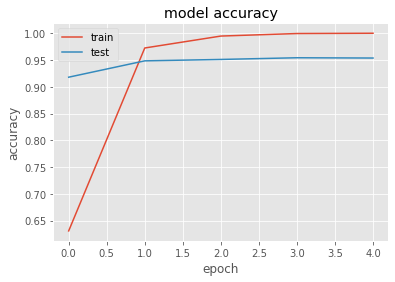

In [39]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


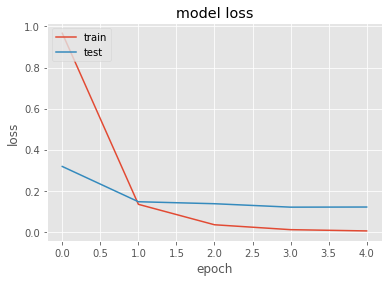

In [40]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Lets look at accuracy**

In [105]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.9425

With simple model we are able to get around 94% accuracy on the test set

**Recurrent Neural Networks(RNN)**

we will use LSTM's to capture the notion of time in our posts. Which means we tend to see certain words after or before some other context word X and we would want to capture that.

In [121]:
inputs = Input(shape =(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size, 128, input_length=MAX_LENGTH)(inputs)
x = Dropout(0.25)(embedding_layer)
x = LSTM(64, dropout=0.5, recurrent_dropout=0.5)(x)
#x = Dropout(0.25)(x)
x = Dense(16, activation = 'relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs = predictions)
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 500, 128)          4270976   
_________________________________________________________________
dropout_9 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_24 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 68        
Total params: 4,321,492
Trainable params: 4,321,492
Non-trainable params: 0
________________________________________________

In [123]:

filepath = 'weights.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, shuffle=True, epochs=5,callbacks=[checkpointer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 5700 samples, validate on 1900 samples
Epoch 1/5
5700/5700 [==============================] - 91s 16ms/step - loss: 1.2373 - acc: 0.4560 - val_loss: 0.7740 - val_acc: 0.7300

Epoch 00001: val_acc improved from -inf to 0.73000, saving model to weights.hdf5
Epoch 2/5
5700/5700 [==============================] - 88s 15ms/step - loss: 0.6616 - acc: 0.7628 - val_loss: 0.4073 - val_acc: 0.8705

Epoch 00002: val_acc improved from 0.73000 to 0.87053, saving model to weights.hdf5
Epoch 3/5
5700/5700 [==============================] - 87s 15ms/step - loss: 0.3633 - acc: 0.8791 - val_loss: 0.3753 - val_acc: 0.8768

Epoch 00003: val_acc improved from 0.87053 to 0.87684, saving model to weights.hdf5
Epoch 4/5
5700/5700 [==============================] - 86s 15ms/step - loss: 0.2604 - acc: 0.9205 - val_loss: 0.3065 - val_acc: 0.9053

Epoch 00004: val_acc improved from 0.87684 to 0.90526, saving model to weights.hdf5
Epoch 5/5
5700/5700 [==============================] - 86s 15ms/step - loss

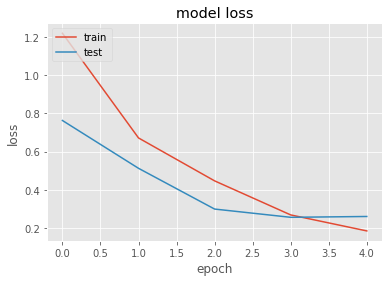

In [114]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

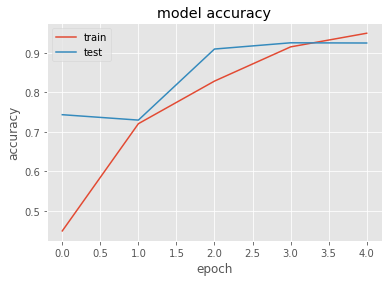

In [115]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
model.load_weights('weights.hdf5')
predicted = model.predict(X_test)

In [76]:
print(predicted)

[[1.9212926e-04 4.3091099e-03 4.2516976e-03 9.9124700e-01]
 [6.2670537e-05 9.9499607e-01 5.7909772e-05 4.8833494e-03]
 [1.9791709e-05 9.9662066e-01 2.5966063e-05 3.3334838e-03]
 ...
 [4.2589258e-05 9.9491763e-01 5.6685229e-05 4.9831131e-03]
 [9.9587774e-01 1.9582075e-03 9.2616881e-04 1.2378347e-03]
 [9.9883300e-01 5.9655728e-04 2.3196907e-04 3.3844355e-04]]


In [77]:
from collections import Counter

l = list(y_test)
e = Counter(l)
e

Counter({0: 101, 1: 89, 2: 108, 3: 102})

**Understanding Softmax**

If you look at the last layer of your neural network you can see that we are setting the output to be equal to number of classes which mean the model will give us the probability that the input is belong to a particular class. Hence to get the predicted we need to use argmax to find the one with highest probability

In [0]:
predicted = np.argmax(predicted, axis=1)

In [0]:
accuracy_score(y_test, predicted)

0.9675

**Bidirectional LSTM**

In [106]:
from keras.layers import Dense, Embedding, Bidirectional, LSTM

inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size, 128, input_length=MAX_LENGTH)(inputs)

x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)
#x = Bidirectional(LSTM(64, dropout=0.2))
x = Dense(16, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model=Model(inputs=[inputs], output = predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 300)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 300, 128)          4270976   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_21 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 68        
Total params: 4,371,924
Trainable params: 4,371,924
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [107]:
filepath = 'weights.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=0, validation_split=0.25,shuffle=True, epochs=10, callbacks=[checkpointer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Epoch 00001: val_acc improved from -inf to 0.94737, saving model to weights.hdf5

Epoch 00002: val_acc improved from 0.94737 to 0.95842, saving model to weights.hdf5

Epoch 00003: val_acc did not improve from 0.95842

Epoch 00004: val_acc did not improve from 0.95842

Epoch 00005: val_acc did not improve from 0.95842

Epoch 00006: val_acc did not improve from 0.95842

Epoch 00007: val_acc did not improve from 0.95842

Epoch 00008: val_acc improved from 0.95842 to 0.96105, saving model to weights.hdf5

Epoch 00009: val_acc did not improve from 0.96105

Epoch 00010: val_acc did not improve from 0.96105


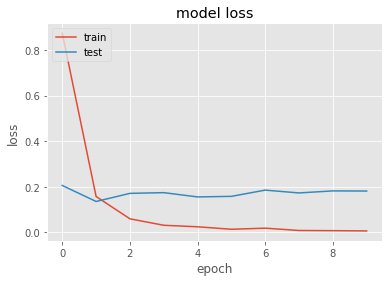

In [108]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

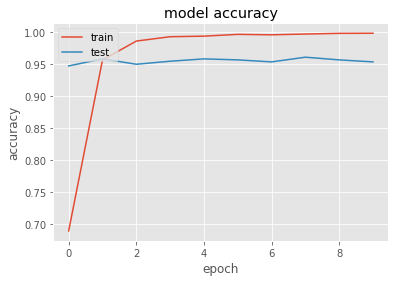

In [109]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
model.load_weights('weights.hdf5')
predicted = model.predict(X_test)

In [0]:
predicted = np.argmax(predicted, axis=1)

In [112]:
accuracy_score(y_test, predicted)

0.945